<img src="./img/oscon.png" width="400">

# Abstraction layers 

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib import cm
import itertools
import numpy as np
from tensorflow.contrib import learn
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import layers
from sklearn import datasets, metrics, preprocessing
from sklearn import model_selection
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Dense, Flatten
from keras.models import Model
from keras.datasets import cifar10
from keras import utils
from keras.datasets import mnist
import sys

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# learn
~~~python 
from tensorflow.contrib import learn
~~~

## Estimators
### 1. Instantiate the Estimator class
~~~python 
model = learn.<Estimator>()
~~~
### 2.  Fit it using training data
~~~python 
model.fit()
~~~
### 3. Evaluate how good is the fit
~~~python 
model.evaluate()
~~~
### 4. Predict outcomes on new data
~~~python 
model.predict()
~~~



# Deep Neural Network Estimator

In [9]:
tf.logging.set_verbosity(tf.logging.ERROR)

DATA_DIR = '/tmp/data' if not 'win32' in sys.platform else "c:\\tmp\\data"
data_one_hot = input_data.read_data_sets(DATA_DIR, one_hot=True)

data_classes = input_data.read_data_sets(DATA_DIR, one_hot=False)
x_data, y_data = data_classes.train.images,data_classes.train.labels.astype(np.int32)
x_test, y_test = data_classes.test.images,data_classes.test.labels.astype(np.int32)

Extracting c:\tmp\data\train-images-idx3-ubyte.gz
Extracting c:\tmp\data\train-labels-idx1-ubyte.gz
Extracting c:\tmp\data\t10k-images-idx3-ubyte.gz
Extracting c:\tmp\data\t10k-labels-idx1-ubyte.gz
Extracting c:\tmp\data\train-images-idx3-ubyte.gz
Extracting c:\tmp\data\train-labels-idx1-ubyte.gz
Extracting c:\tmp\data\t10k-images-idx3-ubyte.gz
Extracting c:\tmp\data\t10k-labels-idx1-ubyte.gz


### Labels: one hot vs class number


In [10]:
print('one-hot=False:\n')
print(data_classes.train.labels)
print('\n')
print('one-hot=True:\n')
print(data_one_hot.train.labels)


one-hot=False:

[7 3 4 ..., 5 6 8]


one-hot=True:

[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]


In [11]:
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=10)]

dnn = learn.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[200],
    n_classes=10,
    optimizer=tf.train.ProximalAdagradOptimizer(
      learning_rate=0.2,
    ))

fit = dnn.fit(x=x_data,y=y_data, steps=2000,batch_size=128)
print('Done fitting')

C:\p3\lib\site-packages\tensorflow\python\util\deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Done fitting


In [12]:
ev = dnn.evaluate(x=x_test,y=y_test, steps=1)["accuracy"]
print(ev)

C:\p3\lib\site-packages\tensorflow\python\util\deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


0.9772


 <tr>
    <td> <img src="./img/mnist-digits-small.png"  width="400"/> </td>
    <td> <img src="./img/acc_vs_n_units.png"  width="600"/> </td>
    </tr>

C:\p3\lib\site-packages\tensorflow\python\util\deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


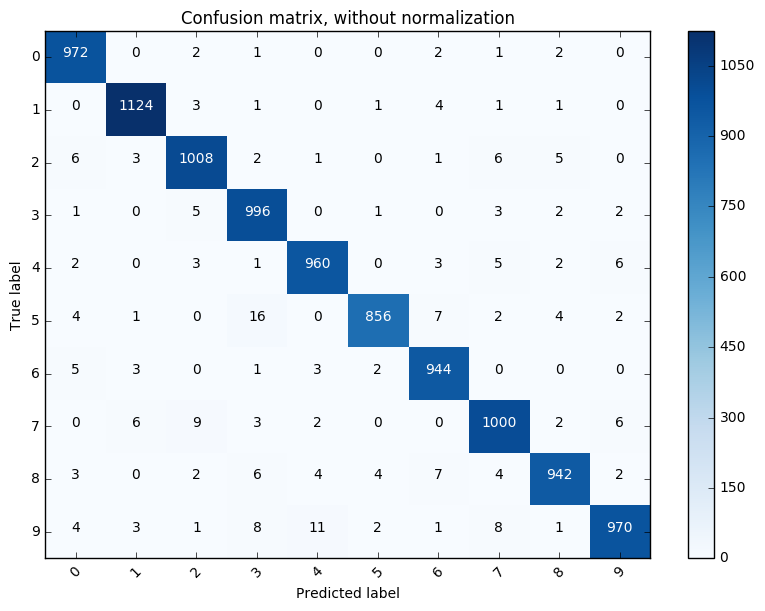

In [13]:
y_pred = dnn.predict(x=x_test,as_iterable=False)
class_names = ['0','1','2','3','4','5','6','7','8','9']    
    
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=[8,6])
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Hands-on 1

In [14]:
tf.logging.set_verbosity(tf.logging.ERROR)

boston = datasets.load_boston()
x_data = preprocessing.StandardScaler().fit_transform(boston.data)
y_data = boston.target
y_data = y_data.reshape(y_data.shape + (1,))
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=0)

The Boston Housing dataset is a relatively small dataset (506 samples), containing information concerning housing in the area of Boston Massachusetts. There are 13 predictors and the target variable is the median value of owner-occupied homes in $1000's 

### Data Set Information:

Concerns housing values in suburbs of Boston.

### Attribute Information:

1. CRIM: per capita crime rate by town 
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to five Boston employment centres 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate per \$10,000 
11. PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population 

In [15]:
feature_columns = learn.infer_real_valued_columns_from_input(x_data)
optimizer = tf.train.GradientDescentOptimizer(0.1)

regressor = learn.LinearRegressor(feature_columns=feature_columns,
                                  optimizer=optimizer)

##############################################
# fit and evalute test data MSE for 1-20 steps
##############################################

plt.figure()
plt.plot(np.arange(20),MSE,lw=3,alpha=0.5)
plt.plot(np.arange(20),MSE,'ko',alpha=0.5)
plt.title('Boston housing test data MSE',fontsize=20)
plt.xlabel('# steps',fontsize=20)
plt.ylabel('MSE',fontsize=20)
plt.show()

NameError: name 'MSE' is not defined

In [ ]:
%load solutions/solution4.py

# Keras
Keras is one of the most popular and powerful TensorFlow extension libraries. In 2017 Keras gained official Google support, and as of version 1.1 is part of its contrib library

## Installation

~~~python 
pip install keras
~~~

Or download from:
[Git page](https://github.com/fchollet/keras)

And install using:

~~~python 
python setup.py install
~~~


# Creating and running a model

***1) We start by defining the shape of the input data***

~~~python 
inputs = Input(shape=(784,))
~~~

***2) Then create layer, passing the input from one to the next***

~~~python 
x = some layer(input)
x = some layer(x)
       ...
       ...
       ...
outputs = last layer(x)
~~~

**3) And now instantiate the model, passing both inputs and outputs**

~~~python 
model = Model(inputs=inputs, outputs=outputs)
~~~
**4) Compile the* model, assigning it with an optimizer, a loss function and metrics***
~~~python 
model.compile(optimizer='adadelta', loss='categorical_crossentropy',metrics=['accuracy'])
~~~

**5) fit by passing the data, and setting the number of epochs and batch size**


model.fit(x_train, y_train, epochs=10, batch_size=64)

**6) Evaluate how it does**


loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)

**7) Predict new samples**

classes = model.predict(x_test, batch_size=64)
~~~

# Keras vs. Native Tensorflow

### Native TensorFlow:

~~~python 
initial = tf.truncated_normal([5, 5, 1, 32], stddev=0.1)
W = tf.Variable(initial)
initial = tf.constant(0, shape=32)
b = tf.Variable(initial)
img = nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
img = tf.nn.relu(img + b)
~~~

### Keras:

~~~python 
init = keras.initializers.RandomNormal(mean=0.0, stddev=0.1)
img = Conv2D(32, (5, 5),
    activation='relu', 
    padding='same',
    kernel_initializer=init,
    bias_initializer='zeros'
    )(inp_img)
~~~

### Native TensorFlow:

~~~python 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_conv, labels = y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess =  tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(STEPS):
    batch = mnist.train.next_batch(MINIBATCH_SIZE)

    if i % 200 == 0:
        valid_accuracy = sess.run(accuracy, 
                                  feed_dict={x: mnist.validation.images, 
                                             y_: mnist.validation.labels,
                                             keep_prob: 1.0})        

    sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    
test_accuracy = np.mean([sess.run(accuracy, feed_dict={x:x_test, y_:y_test, 
~~~
                                              keep_prob:1.0}) for i in range(10)])    
### Keras:

~~~python 
model.compile(optimizer='adadelta', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, y_test)
               )
model.evaluate(x_test,y_test)
~~~


# CNN for image classification (MNIST)

In [ ]:
DATA_DIR = '/tmp/data' if not 'win32' in sys.platform else "c:\\tmp\\data"
data = input_data.read_data_sets(DATA_DIR, one_hot=True)
x_train, y_train = data.train.images,data.train.labels.astype(np.int32)
x_test, y_test = data.test.images,data.test.labels.astype(np.int32)

In [ ]:
x_train = np.reshape(x_train, [-1, 28, 28, 1])
x_test = np.reshape(x_test, [-1, 28, 28, 1])

In [ ]:
inp_img = Input(shape=(28, 28, 1))  
img = Conv2D(32, (5, 5), activation='relu', padding='same')(inp_img)
img = MaxPooling2D((2, 2), padding='same')(img)
img = Conv2D(64, (5, 5), activation='relu', padding='same')(img)             
img = MaxPooling2D((2, 2), padding='same')(img)
img = Flatten()(img)
img = Dense(1024,activation="relu")(img)
img = Dropout(0.5)(img)
decoded = Dense(10,activation="softmax")(img)

In [ ]:
cnn = Model(inp_img, decoded)
cnn.compile(optimizer='adadelta', loss='categorical_crossentropy',metrics=['accuracy'])

cnn.fit(x_train, y_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, y_test)
               )

In [ ]:
loss_and_metrics = cnn.evaluate(x_test, y_test, batch_size=64)
print(loss_and_metrics)

# CNN for image classification (Cifar10)

# Autoencoders
Output a reconstruction of the input after having its dimensionality reduced in the process

Autoencoders create a bottleneck layer, called a hidden layer that has a smaller number of units than the input layer, forcing the data to be compressed before reconstructed. For the reconstruction (decoding) to be done efficiently, autoencoders extract representative features that capture some hidden abstraction.

<img src="./img/autoencoders2.png" width="800">

### Load Cifar10 data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Take only images of class '1'

In [ ]:
x_train = x_train[np.where(y_train==1)[0],:,:,:]
x_test = x_test[np.where(y_test==1)[0],:,:,:]

### converting our data to float32 and and normalize it to range between [0,1]. 

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

### Then we add some Gaussian noise, and clip values that are either smaller than 0 or larger than 1.

In [ ]:
x_train_n = x_train + 0.5 * np.random.normal(loc=0.0, scale=0.4, size=x_train.shape) 
x_test_n = x_test + 0.5 * np.random.normal(loc=0.0, scale=0.4, size=x_test.shape) 

x_train_n = np.clip(x_train_n, 0., 1.)
x_test_n = np.clip(x_test_n, 0., 1.)

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_n[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We declare the input layer (every image in CIFAR is 32x32 pixels with RGB channels)



In [ ]:
inp_img = Input(shape=(32, 32, 3))  

Our first layer is a 2D convolution layer, where the first argument is the number of filters (and thus the number of output images), and the second is the size of each filter.

In [ ]:
img= Conv2D(32, (3, 3), activation='relu', padding='same')(inp_img)

Next, we add more "legos" layers: we add a 2x2 pooling layer , another convolution layer, an up-sampling (repeating the rows and columns of the data to get back the same number of pixels in each image), and finally a convolutional output layer where we go back to 3 channels. 

In [ ]:
img = MaxPooling2D((2, 2), padding='same')(img)
img = Conv2D(32, (3, 3), activation='relu', padding='same')(img)
img = UpSampling2D((2, 2))(img)
out_img = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(img)

We declare the functional model format, passing both inputs and ouputs. 



In [ ]:
autoencoder = Model(inp_img, out_img)

We compile the model, declaring the loss function and the optimizer, in this case the Adagrad optimizer. 

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train_n, x_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_n, x_test))

In [ ]:
n_imgs = 10
f,axarr = plt.subplots(2,n_imgs,figsize=[20,10])
decoded_imgs = autoencoder.predict(x_test_n)
for i in range(n_imgs):
    ax = axarr[0,i]
    ax.imshow(x_test_n[i,:,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = axarr[1,i]
    ax.imshow(decoded_imgs[i,:,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
            
plt.tight_layout()
plt.show()

# Denoising results for different epochs

<img src="./img/denoising_cifar.png" width="800">

# Hands on 2
### Denoise MNIST data

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [ ]:
noise_factor = 0.5

x_train_n = x_train + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_n = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_n = np.clip(x_train_n, 0., 1.)
x_test_n = np.clip(x_test_n, 0., 1.)


input_img = Input(shape=(28, 28, 1))  


- ***2D convolution with 32  3x3 filters + relu activation function***
- *** max pooling with 2x2*** (compress)
- ***2D convolution with 32  3x3 filters + relu activation function***
- *** max pooling with 2x2*** (compress)


- ***2D convolution with 32  3x3 filters + relu activation function***
- *** max upsampling with 2x2*** (decompress)
- ***2D convolution with 32  3x3 fil ters + relu activation function***
- *** max upsampling with 2x2*** (decompress)
- ***2D convolution with 1  3x3 filters + sigmoid activation function***


decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(im)


In [ ]:
n_imgs = 10
f,axarr = plt.subplots(2,n_imgs,figsize=[20,5])
for i in range(n_imgs):
    ax = axarr[0,i]
    ax.imshow(x_test_n[i,:,:,0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = axarr[1,i]
    ax.imshow(decoded_imgs[i,:,:,0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
            
plt.tight_layout()
plt.show()

In [ ]:
# %load solutions/solution5.py



input_img = Input(shape=(28, 28, 1))  
im = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
im = MaxPooling2D((2, 2), padding='same')(im)
im = Conv2D(32, (3, 3), activation='relu', padding='same')(im)
encoded = MaxPooling2D((2, 2), padding='same')(im)


im = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
im = UpSampling2D((2, 2))(im)
im = Conv2D(32, (3, 3), activation='relu', padding='same')(im)
im = UpSampling2D((2, 2))(im)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(im)

model = Model(input_img, decoded)
model.compile(optimizer='adadelta', loss='binary_crossentropy')

model.fit(x_train_noisy, x_train,
                epochs=1,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

decoded_imgs = model.predict(x_test_n)

n_imgs = 10
f,axarr = plt.subplots(2,n_imgs,figsize=[20,5])
for i in range(n_imgs):
    ax = axarr[0,i]
    ax.imshow(x_test_n[i,:,:,0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = axarr[1,i]
    ax.imshow(decoded_imgs[i,:,:,0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
            
plt.tight_layout()
plt.show()